# Imports

In [1]:
import requests
from PIL import Image
import matplotlib.pyplot as plt

from transformers import CLIPImageProcessor, AutoTokenizer

import torch



# Load custom modules

In [2]:
import sys
import os
sys.path.append("../../../")

from lxmls.multimodal.clip_base import *

from lxmls.transformers.utils import set_seed
from lxmls.transformers.bpe import BPETokenizer
from lxmls.transformers.model import GPT

# CLIP exercise

In [3]:
# Preparing input data

# Download example image for illustration
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

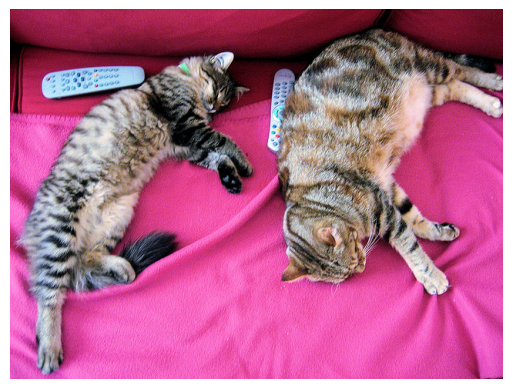

In [4]:
# Plot the image
plt.imshow(image)
plt.axis("off")

In [5]:
# Start of an input string

str_start = "The animal on the picture is a type of"



In [6]:
# Initialize a GPT model (previous day exercise) 

In [7]:
model_type = 'gpt2'
model = GPT.from_pretrained(model_type)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# We move the model to device in case we want to exploit gpu acceleration
# we also set it to eval mode since we are not interested in computing or storing any gradients
model.to(device)
model.eval();

number of parameters: 124.44M


In [8]:
str_comp = model.prompt_topK(str_start, 1, 5)

--------------------------------------------------------------------------------
The animal on the picture is a type of cat
--------------------------------------------------------------------------------
The animal on the picture is a type of rabbit
--------------------------------------------------------------------------------
The animal on the picture is a type of dog
--------------------------------------------------------------------------------
The animal on the picture is a type of black
--------------------------------------------------------------------------------
The animal on the picture is a type of p


# Load the CLIP model

In [9]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Choose device dynamically
model = model.to(device)

# easier than having `with torch.no_grad` everywhere
for p in model.parameters():
    p.requires_grad = False

# Load existing image processor
processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [10]:
# Convert the image using the processor
# Show the raw pixel values 
# -> note they have been normalized so we will get warnings from pyplot that expects values in [0, 1]
image_inputs = processor([image], return_tensors="pt")
image_inputs["pixel_values"]

tensor([[[[ 0.5873,  0.5873,  0.6165,  ...,  0.0617,  0.0471, -0.0259],
          [ 0.5727,  0.5727,  0.6603,  ...,  0.1201,  0.0763,  0.0909],
          [ 0.5873,  0.5435,  0.6165,  ...,  0.0325,  0.1201,  0.0617],
          ...,
          [ 1.8719,  1.8573,  1.8719,  ...,  1.3902,  1.4340,  1.4194],
          [ 1.8281,  1.8719,  1.8427,  ...,  1.4486,  1.4340,  1.5070],
          [ 1.8573,  1.9011,  1.8281,  ...,  1.3756,  1.3610,  1.4486]],

         [[-1.3169, -1.3019, -1.3169,  ..., -1.4970, -1.4369, -1.4820],
          [-1.2418, -1.2718, -1.2268,  ..., -1.4369, -1.4669, -1.4519],
          [-1.2568, -1.3169, -1.2268,  ..., -1.4669, -1.4069, -1.4519],
          ...,
          [ 0.1239,  0.1089,  0.1239,  ..., -0.7016, -0.6865, -0.6865],
          [ 0.0789,  0.0939,  0.0488,  ..., -0.6565, -0.6865, -0.6115],
          [ 0.0939,  0.1089,  0.0038,  ..., -0.7766, -0.7316, -0.6115]],

         [[-0.4848, -0.4137, -0.3853,  ..., -0.9541, -0.8545, -0.8545],
          [-0.4137, -0.4706, -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

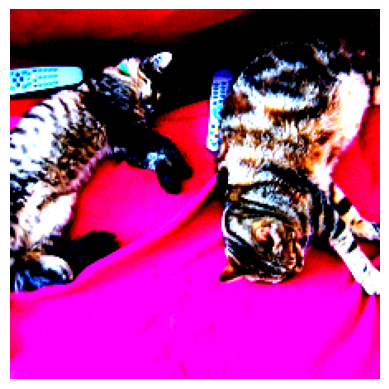

In [11]:
# Plot the image after processing
plt.imshow(image_inputs["pixel_values"].squeeze().transpose(0,2).transpose(0,1))
plt.axis("off")

In [12]:
# Load a tokenizer
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [13]:
# Tokenize the text generated by gpt2
text_inputs=tokenizer(str_comp, return_tensors="pt", truncation=True, padding="longest")

In [14]:
# handle device
for k,v in text_inputs.items():
    text_inputs[k]=v.to(model.device)

for k,v in image_inputs.items():
    image_inputs[k]=v.to(model.device)

In [15]:
# embed text -> straightforward, you should already know
text_embedding = model.text_model(**text_inputs).pooler_output

Vision Transformer (ViT) splits the image into fixed size patches of shape `(patch_size, patch_size)`, see [Dosovitskiy et al. 2021](https://openreview.net/forum?id=YicbFdNTTy)

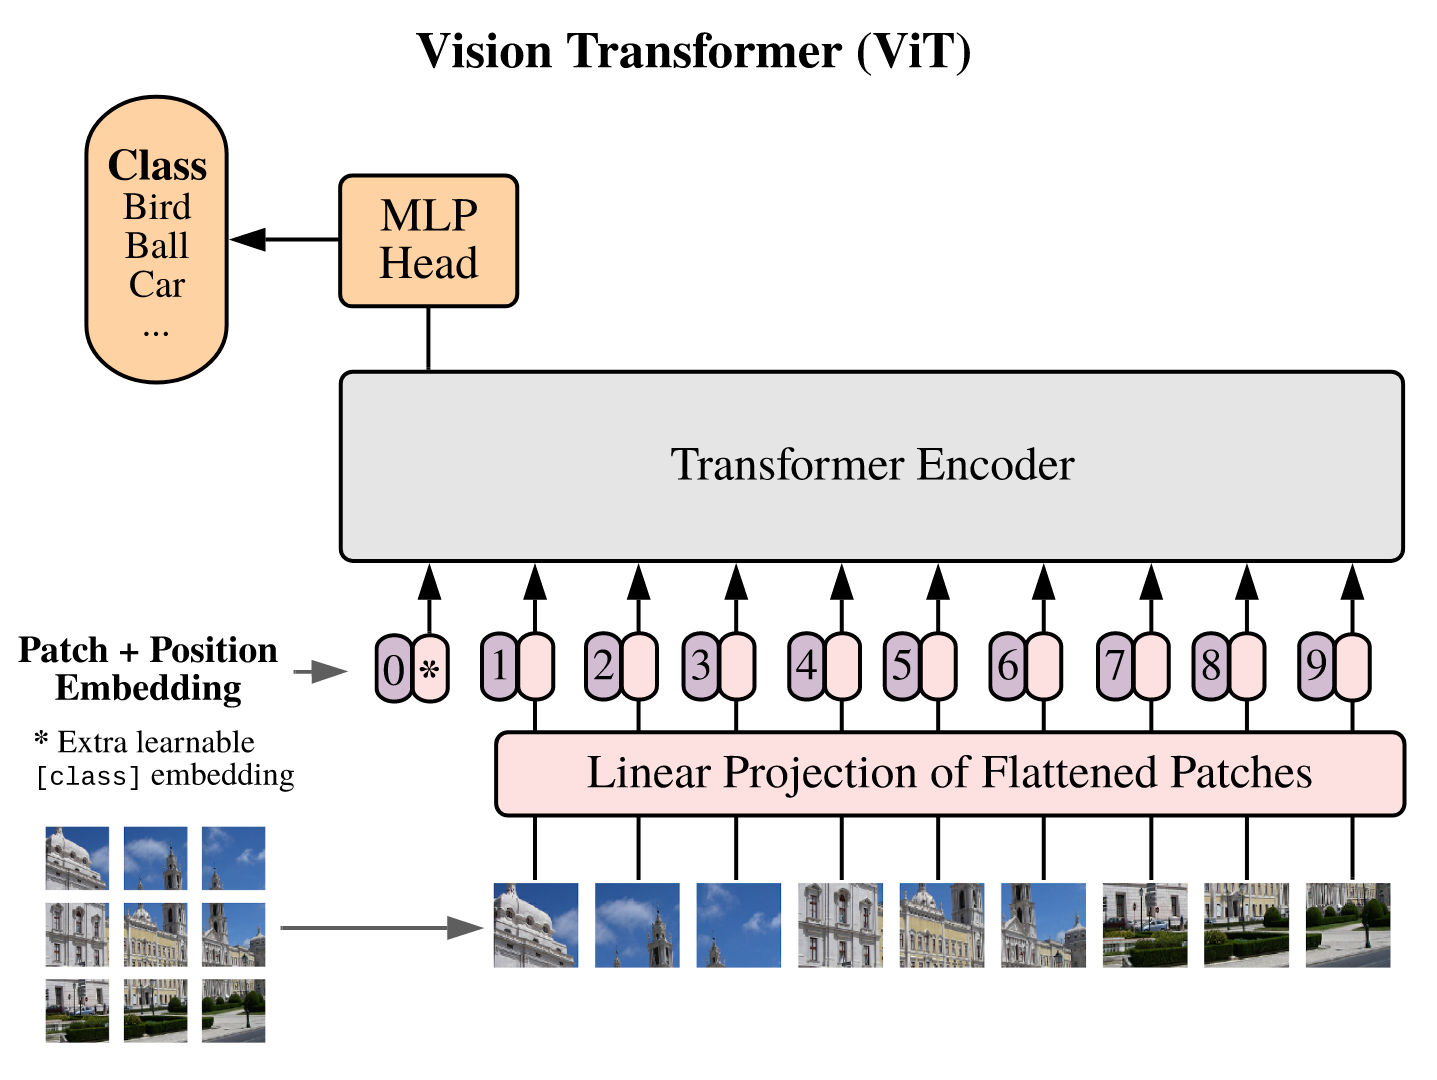

While this is often implemented as a convolution we implement it here as described in the paper

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6920661..0.8354542].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7070738..0.9668401].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7220815..2.1316772].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.0463567].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..0.9514116].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..1.2500329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.792262

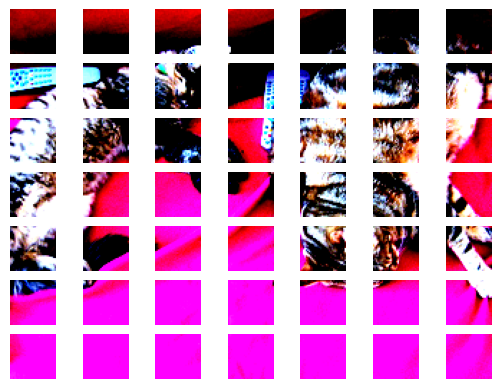

In [16]:
# plot of image patches
pixel_values = image_inputs["pixel_values"]
batch_size, num_channels, height, width = pixel_values.shape
target_dtype = model.vision_model.embeddings.patch_embedding.weight.dtype
pixel_values = pixel_values.to(dtype=target_dtype)
assert height==width
patch_size=model.vision_model.embeddings.patch_size
num_patches = width//patch_size
fig,axes = plt.subplots(num_patches, num_patches)
for i in range(num_patches):
    for j in range(num_patches):
        patch = pixel_values[0,:,i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size]
        axes[i,j].imshow(patch.transpose(0,2).transpose(0,1).cpu())
        axes[i,j].axis("off")

In [17]:
# these are the learned weights for the linear projection
filter_weights = model.vision_model.embeddings.patch_embedding.weight.reshape(-1, patch_size*patch_size*num_channels)
filter_weights.shape

torch.Size([768, 3072])

In [18]:
def get_patch_embeddings(pixel_values, filter_weights):
    """using a similar code as the visualization above, project the image patches in the embedding space"""
    assert len(pixel_values) == 1 # we do it for a single image for the example and keep the same code as visualization above
    manual_patch_embeds = torch.zeros(num_patches, num_patches, filter_weights.shape[0], device=model.device)
    
    #BEGIN SOLUTION
    for i in range(num_patches):
        for j in range(num_patches):
            patch = pixel_values[0,:,i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size]
            manual_patch_embeds[i,j]=patch.reshape(-1)@filter_weights.T
    #END SOLUTION
    
    return manual_patch_embeds

In [19]:
manual_patch_embeds = get_patch_embeddings(pixel_values, filter_weights)
print(manual_patch_embeds.shape)
# flatten the patch dimension
manual_patch_embeds=manual_patch_embeds.reshape(num_patches*num_patches,-1).unsqueeze(0)
manual_patch_embeds.shape

torch.Size([7, 7, 768])


torch.Size([1, 49, 768])

In [20]:
# lets compare to the original implementation to make sure
# (model.vision_model.embeddings.patch_embedding is a Conv2d layer)
patch_embeds = model.vision_model.embeddings.patch_embedding(pixel_values)
patch_embed_flat = patch_embeds.flatten(2).transpose(1, 2)
assert torch.isclose(manual_patch_embeds, patch_embed_flat, atol=1e-5).all()

AssertionError: 

In [21]:
def get_add_cls_and_position(manual_patch_embeds):
    """The only thing left to do is to add class and position embedding"""
    class_embeds = model.vision_model.embeddings.class_embedding.expand(batch_size, 1, -1)
    hidden_states = torch.cat([class_embeds, manual_patch_embeds], dim=1)
    
    #BEGIN SOLUTION    
    hidden_states = hidden_states + model.vision_model.embeddings.position_embedding(model.vision_model.embeddings.position_ids)
    #END SOLUTION
    
    hidden_states = model.vision_model.pre_layrnorm(hidden_states)
    return hidden_states


In [22]:
hidden_states = get_add_cls_and_position(manual_patch_embeds)

In [23]:
# then we can feed the embeddings to the Transformer like for the text encoder!
encoder_outputs = model.vision_model.encoder(inputs_embeds=hidden_states)

In [24]:
last_hidden_state = encoder_outputs.last_hidden_state
# CLS pooling
pooled_output = last_hidden_state[:, 0, :]
image_embedding = model.vision_model.post_layernorm(pooled_output)

Finally, the time has come to compute image-text similarity

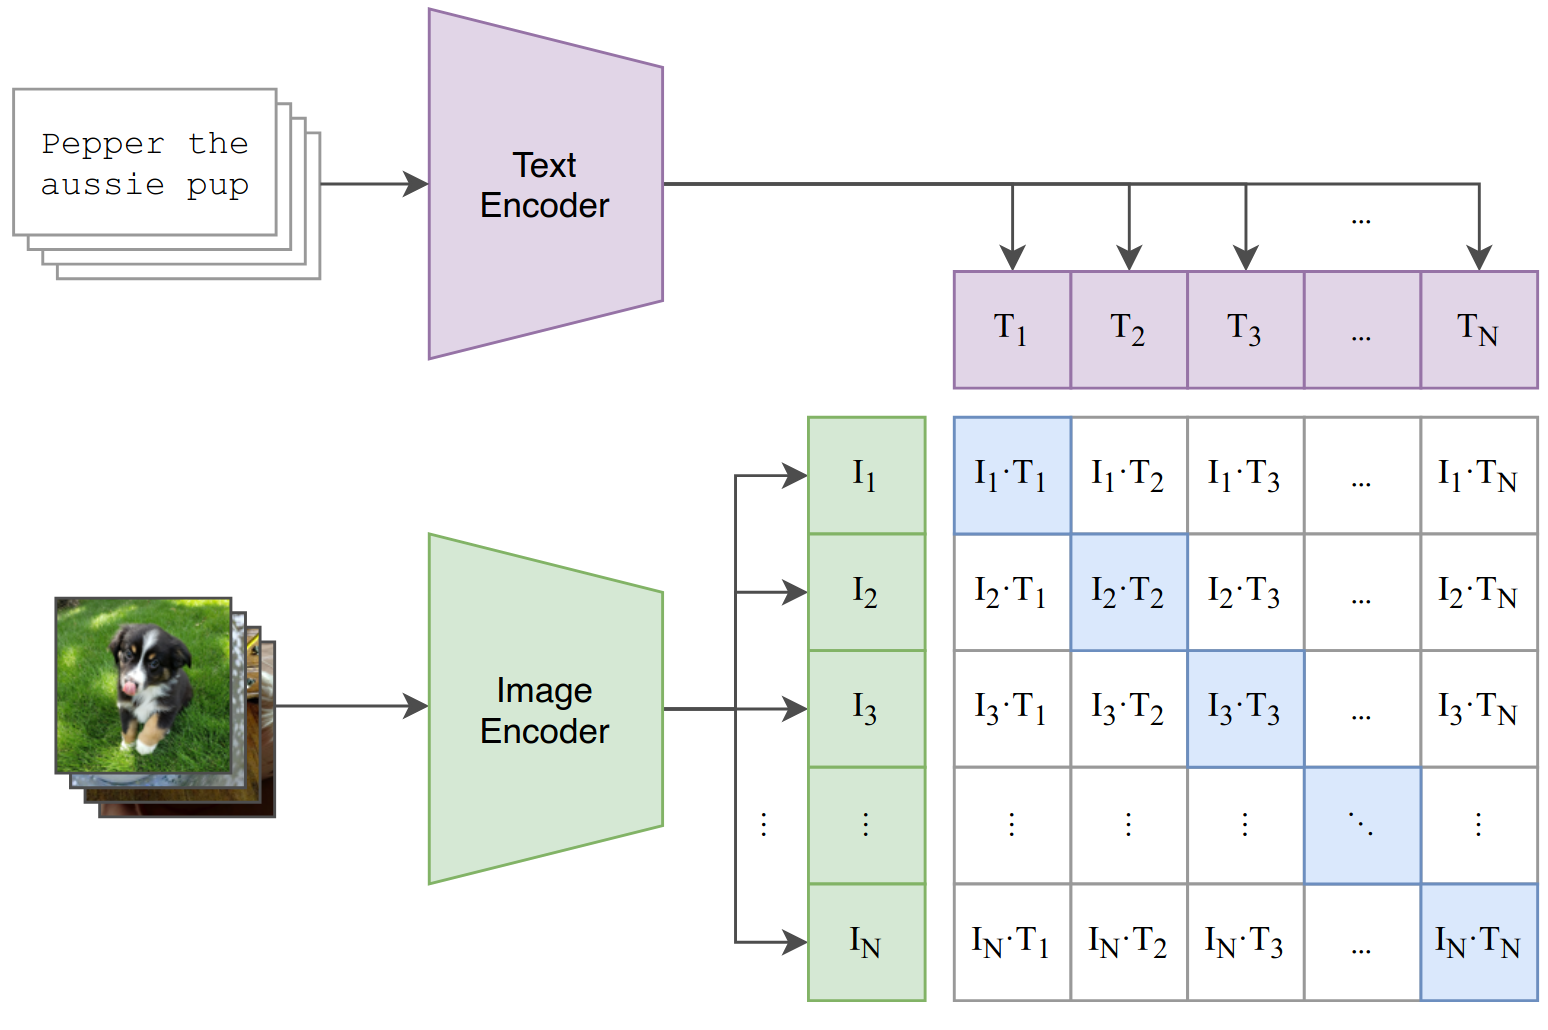

In [25]:
text_embedding = model.text_projection(text_embedding)
image_embedding = model.visual_projection(image_embedding)

In [26]:
def get_sim(text_embedding, image_embedding):
    
    #BEGIN SOLUTION    
    text_embedding/=text_embedding.norm(dim=1, keepdim=True)
    image_embedding/=image_embedding.norm(dim=1, keepdim=True)
    similarities = image_embedding@text_embedding.T
    #END SOLUTION
    
    return similarities

In [27]:
similarities = get_sim(text_embedding, image_embedding)

In [28]:
def rerank(similarities):
    """All is left to do is sort the similarities to rerank the text"""
    
    #BEGIN SOLUTION    
    ranking = similarities.argsort(dim=1, descending=True)
    #END SOLUTION

    return ranking

In [29]:
ranking = rerank(similarities)
assert ranking.shape[0] == 1
for i in ranking[0]:
    print(f"{str_comp[i.item()]} - {similarities[0,i].item():.3f}")

The animal on the picture is a type of cat - 0.239
The animal on the picture is a type of p - 0.223
The animal on the picture is a type of black - 0.216
The animal on the picture is a type of rabbit - 0.206
The animal on the picture is a type of dog - 0.204


## Text-to-image search

In [30]:
# Get several different images
i_urls = {}
i_urls["bird"]= "http://images.cocodataset.org/val2017/000000324158.jpg"
i_urls["dog"] = "http://images.cocodataset.org/val2017/000000000139.jpg"
i_urls["car"] = "http://images.cocodataset.org/val2017/000000458755.jpg"
i_urls["cat"] = url

c_imgs = {}

for i in i_urls.keys():
    print(i_urls[i])
    c_imgs[i] = Image.open(requests.get(i_urls[i], stream=True).raw)

http://images.cocodataset.org/val2017/000000324158.jpg
http://images.cocodataset.org/val2017/000000000139.jpg
http://images.cocodataset.org/val2017/000000458755.jpg
http://images.cocodataset.org/val2017/000000039769.jpg


In [31]:
# Get a quick embedding for the image
def cst_img_emb(img):
    image_inputs = processor([img], return_tensors="pt")

    for k,v in image_inputs.items():
        image_inputs[k]=v.to(model.device)    

    pixel_values = image_inputs["pixel_values"]
    patch_embeds = model.vision_model.embeddings.patch_embedding(pixel_values)
    patch_embed_flat = patch_embeds.flatten(2).transpose(1, 2)

    hidden_states = get_add_cls_and_position(patch_embed_flat)
    encoder_outputs = model.vision_model.encoder(inputs_embeds=hidden_states)
    last_hidden_state = encoder_outputs.last_hidden_state

    pooled_output = last_hidden_state[:, 0, :]
    image_embedding = model.vision_model.post_layernorm(pooled_output)

    return(model.visual_projection(image_embedding))

In [32]:
# Store all embeddings in a matrix
img_emb = []
for i in c_imgs.keys():
    img_emb.append(cst_img_emb(c_imgs[i]))

img_emb = torch.cat(list(img_emb), dim=0) 
                   



In [33]:
# Get an image search based on the text
def img_srch(inp_txt, img_emb):
    text_inputs=tokenizer([inp_txt], return_tensors="pt", truncation=True, padding="longest")

    for k,v in text_inputs.items():
        text_inputs[k]=v.to(model.device)

    text_embedding = model.text_model(**text_inputs).pooler_output
    text_embedding = model.text_projection(text_embedding)

   
    img_similarities = get_sim(img_emb,text_embedding)
    ranking = rerank(img_similarities)

    result = ranking[0][0].detach().cpu().item()

    plt.imshow(c_imgs[list(c_imgs.keys())[result]])
    plt.axis("off")


Enter your search string: dog


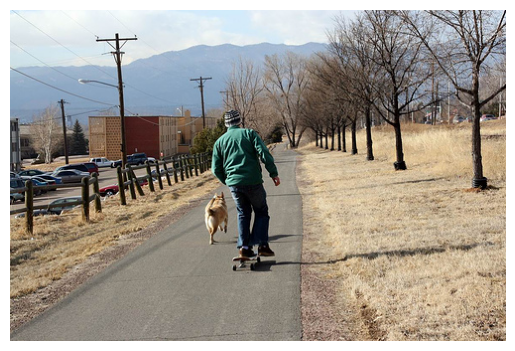

In [34]:
inp_txt = str(input("Enter your search string:"))
img_srch(inp_txt,img_emb)